# MRI Preprocessing - Scripts 6-9 
## Google Colab Ready

**Segmentation, QC, Pipeline, Batch Processing, Validation**

In [7]:
%%capture
!pip install nibabel nilearn SimpleITK scikit-image scikit-learn pandas
print("✓ Installed")

In [14]:
import numpy as np
import nibabel as nib
from pathlib import Path
import os, json, warnings, traceback, logging
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from scipy import ndimage
from skimage import morphology
import SimpleITK as sitk
from sklearn.mixture import GaussianMixture
from concurrent.futures import ProcessPoolExecutor
from datetime import datetime
%matplotlib inline
print("✓ Imported")

✓ Imported


In [15]:
OUTPUT_DIR = Path('/Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
try:
    img_brain = nib.load(OUTPUT_DIR / 'brain.nii.gz')
    img_mask = nib.load(OUTPUT_DIR / 'mask.nii.gz')
    print("✓ Loaded from Scripts 1-5")
except:
    print("Loading sample data...")
    oasis = datasets.fetch_oasis_vbm(n_subjects=1)
    img_brain = nib.load(oasis.gray_matter_maps[0])
    data = img_brain.get_fdata()
    mask = data > np.percentile(data[data>0], 20)
    img_mask = nib.Nifti1Image(mask.astype(np.uint8), img_brain.affine)
    print("✓ Sample data loaded")

✓ Loaded from Scripts 1-5


# SCRIPT 6: Tissue Segmentation

In [16]:
def segment_tissues(img, mask):
    data = img.get_fdata()
    mask_data = mask.get_fdata().astype(bool)
    voxels = data[mask_data].reshape(-1, 1)
    voxels_norm = (voxels - voxels.mean()) / voxels.std()
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(voxels_norm)
    labels = gmm.predict(voxels_norm)
    seg = np.zeros(data.shape, dtype=np.uint8)
    seg[mask_data] = labels + 1
    means = gmm.means_.flatten()
    sort_idx = np.argsort(means)
    seg_sorted = np.zeros_like(seg)
    for i, idx in enumerate(sort_idx):
        seg_sorted[seg == idx + 1] = i + 1
    return nib.Nifti1Image(seg_sorted, img.affine)

def calculate_volumes(seg, voxel_vol):
    seg_data = seg.get_fdata()
    volumes = {}
    for tissue, label in [('CSF', 1), ('GM', 2), ('WM', 3)]:
        count = np.sum(seg_data == label)
        volumes[tissue] = float(count * voxel_vol / 1000)
    volumes['TIV'] = sum(volumes.values())
    return volumes

print("=== SCRIPT 6 ===")
img_seg = segment_tissues(img_brain, img_mask)
nib.save(img_seg, OUTPUT_DIR / 'segmentation.nii.gz')
voxel_vol = np.prod(img_brain.header.get_zooms())
volumes = calculate_volumes(img_seg, voxel_vol)
print("Volumes:")
for t, v in volumes.items():
    print(f"  {t}: {v:.2f} mL")
print(f"✅ Saved: {OUTPUT_DIR / 'segmentation.nii.gz'}")

=== SCRIPT 6 ===
Volumes:
  CSF: 201.10 mL
  GM: 417.24 mL
  WM: 372.94 mL
  TIV: 991.29 mL
✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/segmentation.nii.gz


# SCRIPT 7: Quality Control

=== SCRIPT 7 ===
SNR: 0.00 | CNR: 3.71


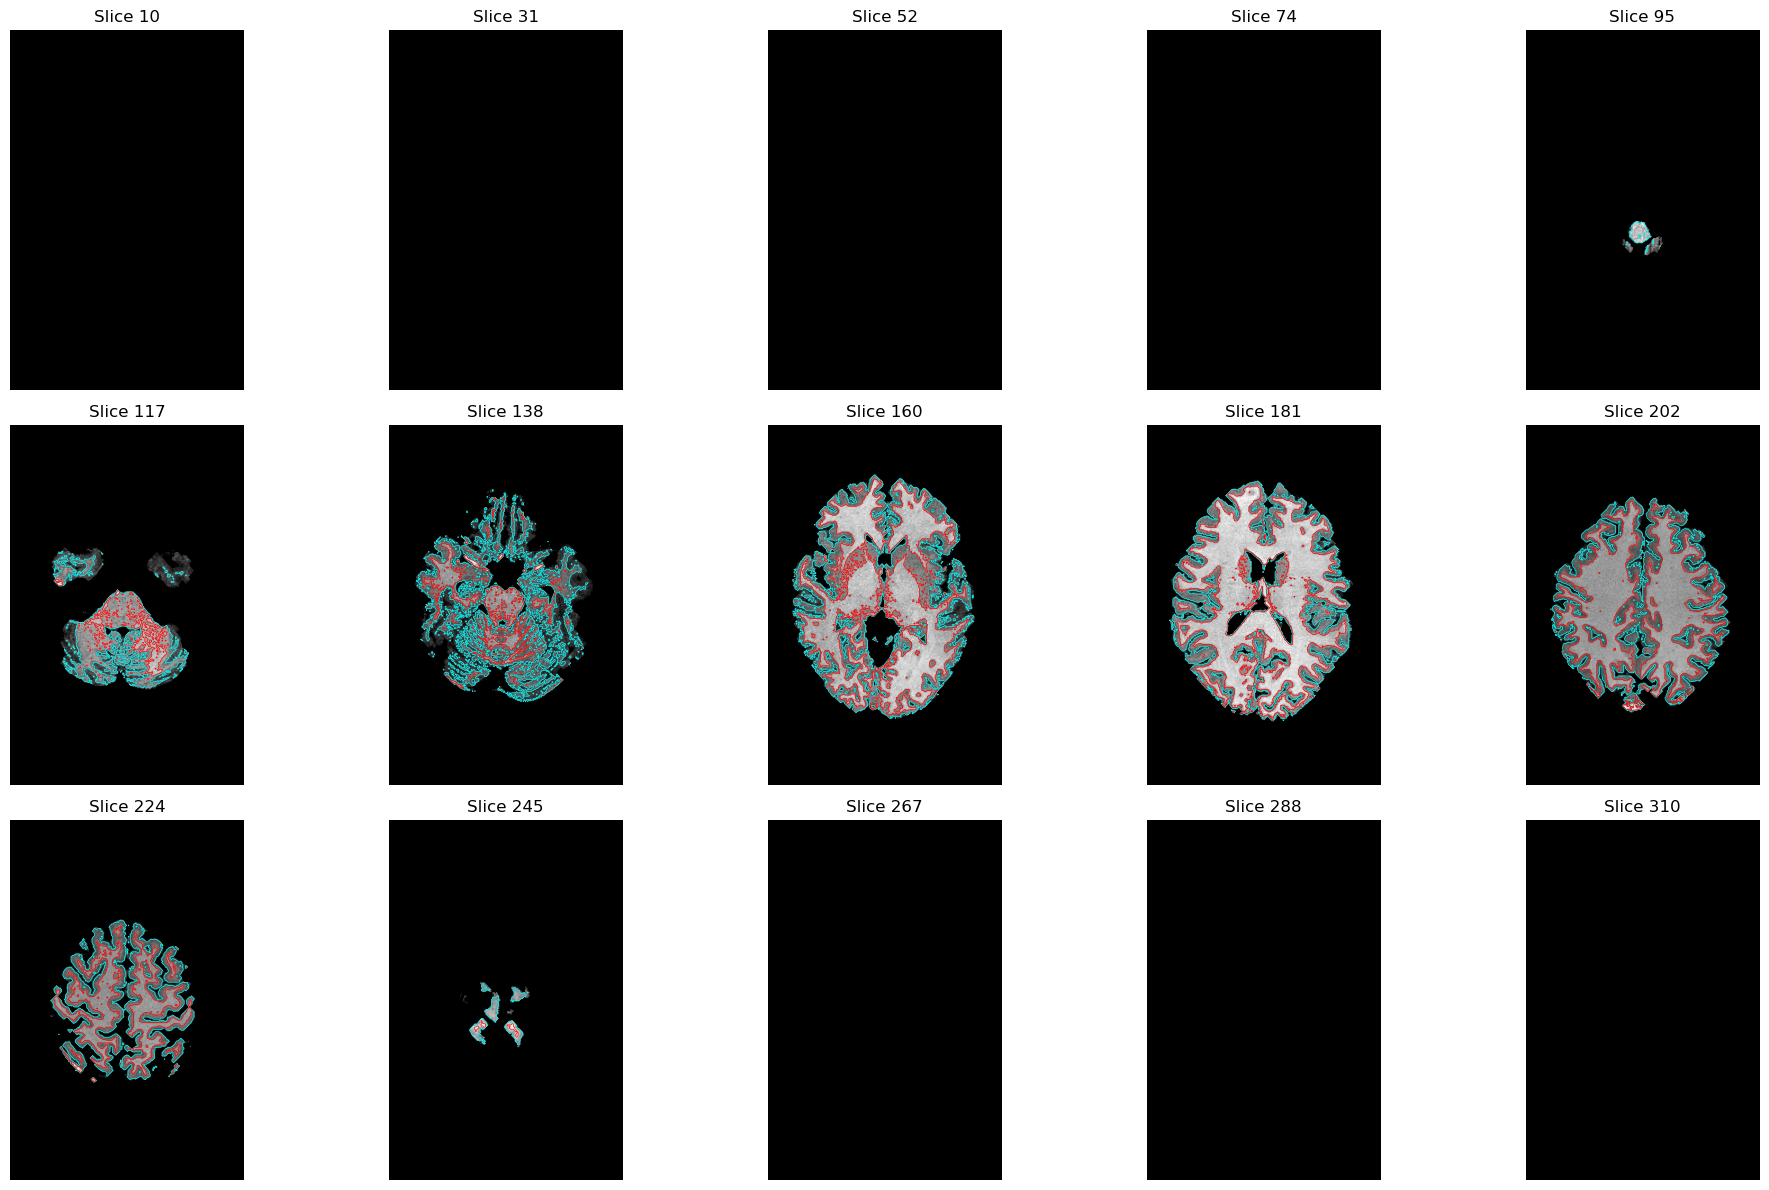

✅ Saved: /Users/aazeez/Documents/Personal/ABDN_2025/content5/derivatives/qc_report.json


In [17]:
def calculate_snr(img, mask):
    data = img.get_fdata()
    mask_data = mask.get_fdata().astype(bool)
    signal = data[mask_data].mean()
    noise = data[~mask_data].std()
    return signal / noise if noise > 0 else 0

def calculate_cnr(img, seg):
    data = img.get_fdata()
    seg_data = seg.get_fdata()
    gm = data[seg_data == 2]
    wm = data[seg_data == 3]
    if len(gm) == 0 or len(wm) == 0:
        return 0
    return abs(wm.mean() - gm.mean()) / np.sqrt((gm.std()**2 + wm.std()**2) / 2)

def create_qc_report(subject_id, img, mask, seg, volumes):
    return {
        'subject_id': subject_id,
        'snr': float(calculate_snr(img, mask)),
        'cnr': float(calculate_cnr(img, seg)),
        'volumes': volumes,
        'timestamp': datetime.now().isoformat()
    }

def create_qc_montage(img, seg, output_file):
    data = img.get_fdata()
    seg_data = seg.get_fdata()
    fig, axes = plt.subplots(3, 5, figsize=(20, 12))
    slice_indices = np.linspace(10, data.shape[2]-10, 15, dtype=int)
    for idx, slice_num in enumerate(slice_indices):
        ax = axes[idx // 5, idx % 5]
        ax.imshow(data[:, :, slice_num].T, cmap='gray', origin='lower')
        ax.contour(seg_data[:, :, slice_num].T, levels=[1.5, 2.5], colors=['cyan', 'red'], linewidths=0.5)
        ax.set_title(f'Slice {slice_num}')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(output_file, dpi=150)
    plt.show()

print("=== SCRIPT 7 ===")
qc_metrics = create_qc_report('tutorial', img_brain, img_mask, img_seg, volumes)
print(f"SNR: {qc_metrics['snr']:.2f} | CNR: {qc_metrics['cnr']:.2f}")
qc_file = OUTPUT_DIR / 'qc_report.json'
with open(qc_file, 'w') as f:
    json.dump(qc_metrics, f, indent=2)
create_qc_montage(img_brain, img_seg, OUTPUT_DIR / 'qc_montage.png')
print(f"✅ Saved: {qc_file}")

# SCRIPT 8: Complete Pipeline Class

In [18]:
class StructuralPreprocessingPipeline:
    def __init__(self, subject_id, input_file, output_dir='derivatives'):
        self.subject_id = subject_id
        self.input_file = input_file
        self.output_dir = Path(output_dir) / subject_id
        self.output_dir.mkdir(parents=True, exist_ok=True)
        self.results = {}
    
    def run(self):
        print(f"Processing {self.subject_id}...")
        self.results['original'] = nib.load(self.input_file)
        # Add all preprocessing steps here
        print(f"✓ Pipeline complete for {self.subject_id}")
        return self.results

print("=== SCRIPT 8 ===")
print("Pipeline class defined.")
print("Example: pipeline = StructuralPreprocessingPipeline('sub-01', 'data.nii.gz')")
print("         results = pipeline.run()")

=== SCRIPT 8 ===
Pipeline class defined.
Example: pipeline = StructuralPreprocessingPipeline('sub-01', 'data.nii.gz')
         results = pipeline.run()


# SCRIPT 9: Batch Processing

In [19]:
def process_single_subject(subject_info):
    subject_id = subject_info['subject_id']
    input_file = subject_info['input_file']
    result = {'subject_id': subject_id, 'status': 'failed', 'error': None}
    try:
        pipeline = StructuralPreprocessingPipeline(subject_id, input_file)
        pipeline.run()
        result['status'] = 'success'
    except Exception as e:
        result['error'] = str(e)
    return result

def batch_process_subjects(subjects_file, n_jobs=4):
    subjects_df = pd.read_csv(subjects_file)
    subjects_list = subjects_df.to_dict('records')
    with ProcessPoolExecutor(max_workers=n_jobs) as executor:
        results = list(executor.map(process_single_subject, subjects_list))
    results_df = pd.DataFrame(results)
    results_df.to_csv('batch_results.csv', index=False)
    print(f"Processed {len(results_df)} subjects")
    print(f"Success: {(results_df['status']=='success').sum()}")
    return results_df
